In [123]:
# Packages
import pandas as pd 
import os
import geopandas as gpd
import matplotlib.pyplot as plt

os.chdir("C:/Users/Soledad.Acuna/Desktop/tesis/data")

banks = pd.read_excel("banks_location.xlsx")
business = pd.read_excel("business.xlsx")
census_map = gpd.read_file("secciones_censales_sociodemo_2014.shp")

CLEAN THE DATA

1. CENSUS SHP

In [124]:
# Filtrar las que comienzan con '08' (BCN), '17' (Girona). '25' (LLeida), '28' (Madrid), '43' (Tarragona)
census_map = census_map[census_map['sscc'].str.startswith(('08', '17', '25', '28', '43'))]
# Función para crear CUSEC
def ajustar_cusec(sscc):
    return sscc[1:] if sscc.startswith('0') else sscc
census_map['CUSEC'] = census_map['sscc'].apply(ajustar_cusec)
# Crear columna 'province'
census_map['province'] = census_map['CUSEC'].apply(lambda x: 'Madrid' if x.startswith('28') else 'Cataluña')

2. BANKS

In [125]:
# Define provinces that belong to Cataluña
provincias_cat = ['BARCELONA', 'GIRONA', 'LLEIDA', 'TARRAGONA']
# # Create new 'province' column with conditions
banks['province'] = banks['PROVINCE'].apply(
    lambda x: 'Cataluña' if x in provincias_cat else ('Madrid' if x == 'MADRID' else None)
)
banks['CUSEC'] = banks['CUSEC'].astype(str)

# Create grouped "entity" column
def normalize_entity(e):
    e = str(e).strip().upper()
    if e == 'CAIXABANK':
        return 'CaixaBank'
    elif e in ['SANTANDER', 'BANCO SANTANDER']:
        return 'Santander'
    elif e == 'BBVA':
        return 'BBVA'
    elif e in ['BANCO DE SABADELL', 'SABADELL']:
        return 'Sabadell'
    elif e == 'BANKINTER':
        return 'Bankinter'
    else:
        return 'Others'
# Apply the function to the original column
banks['entity'] = banks['ENTITY'].apply(normalize_entity)
banks = banks[banks['entity'] != 'Others']

def contar_bancos_por_cusec(df):
    bancos_por_cusec = df.groupby('CUSEC')['NUM_BRANCHES'].sum().reset_index()
    bancos_por_cusec.rename(columns={'NUM_BRANCHES': 'num_bancos'}, inplace=True)
    return bancos_por_cusec

bancos_por_cusec = contar_bancos_por_cusec(banks)

3. MERGE CENSUS + BANKS = RESUMEN

In [126]:
# Unir census_map con el conteo de bancos por CUSEC
resumen = census_map.merge(bancos_por_cusec, on='CUSEC', how='left')
# Asignar 0 a CUSEC sin bancos
resumen['num_bancos'] = resumen['num_bancos'].fillna(0)
# Asegurar que es un GeoDataFrame válido
resumen = gpd.GeoDataFrame(resumen, geometry='geometry', crs=census_map.crs)

4. MERGE RESUMEN + BUSINESS

In [127]:
business['Empresas_Med_Grande'] = (
    business['Between5000001And25000000_Billing'] +
    business['Between25000001And50000000_Billing'] +
    business['MoreThan50000000_Billing']
)
# Asegurar que ambos CUSEC sean del mismo tipo
business['CUSEC'] = business['CUSEC'].astype(str)
# Unir los datos de empresas al GeoDataFrame
resumen = resumen.merge(
    business[['CUSEC', 'Empresas_Med_Grande', 'total_NumCompanies', 'total_NumCompaniesNewCreation']],
    on='CUSEC',
    how='left'
)
# Rellenar NaN con 0
resumen['Empresas_Med_Grande'] = resumen['Empresas_Med_Grande'].fillna(0)
resumen['total_NumCompanies'] = resumen['total_NumCompanies'].fillna(0)
resumen['total_NumCompaniesNewCreation'] = resumen['total_NumCompaniesNewCreation'].fillna(0)

MAPS

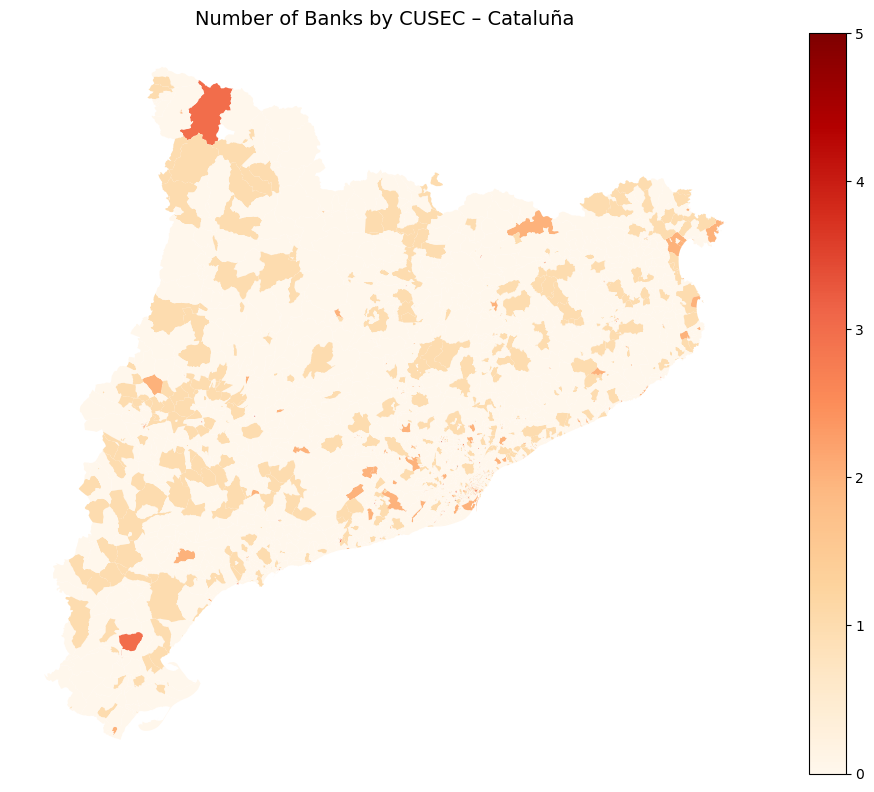

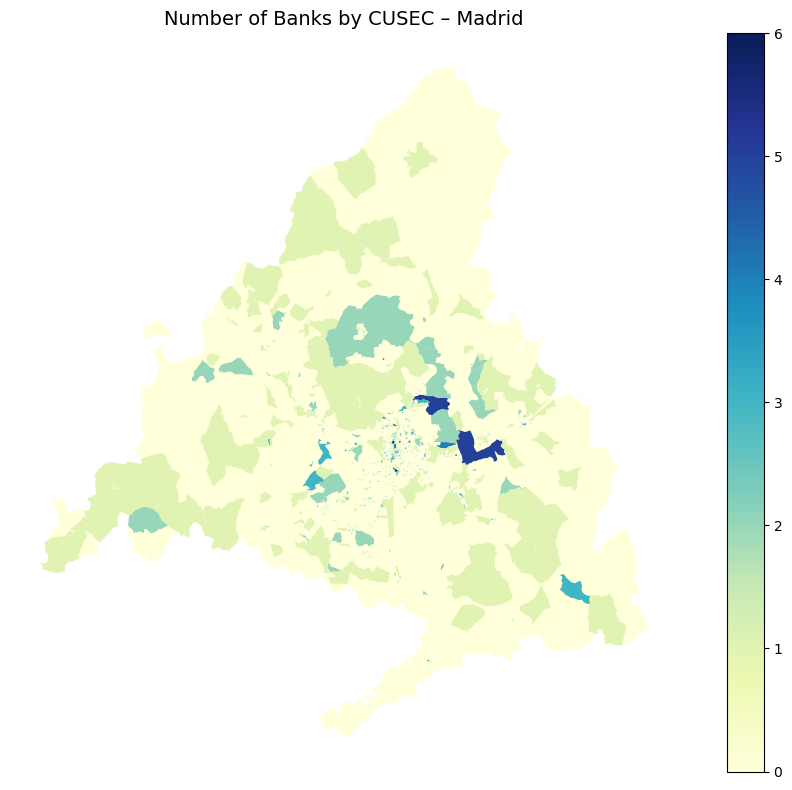

In [128]:
# Separar por provincia
resumen_cat = resumen[resumen['province'] == 'Cataluña']
resumen_mad = resumen[resumen['province'] == 'Madrid']

# Mapa de Cataluña
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='num_bancos', cmap='OrRd', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Number of Banks by CUSEC – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='num_bancos', cmap='YlGnBu', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Number of Banks by CUSEC – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


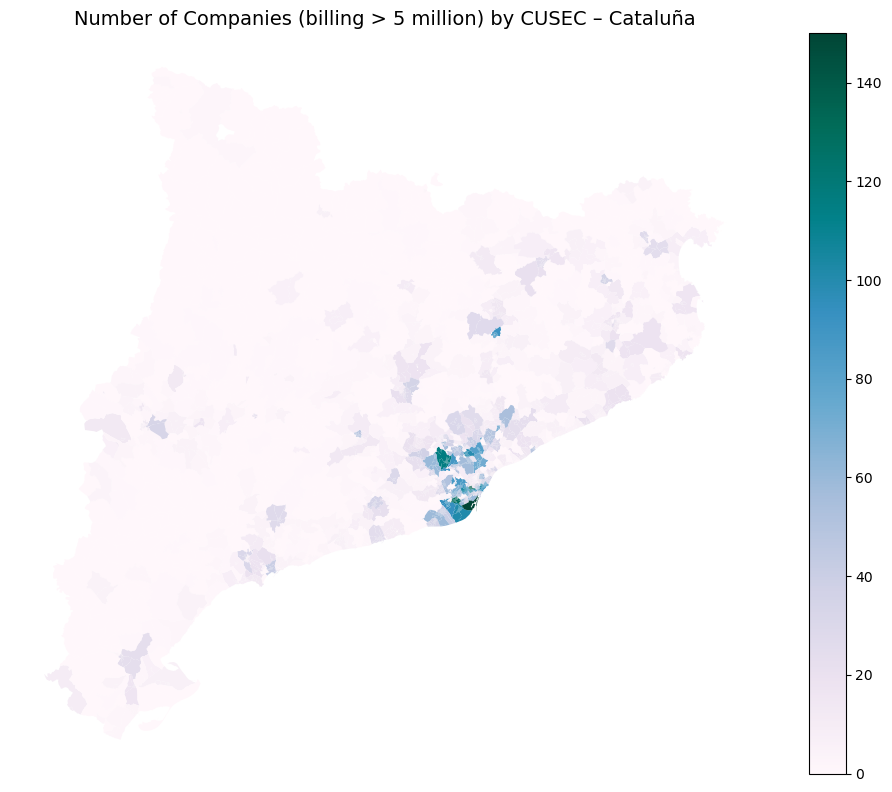

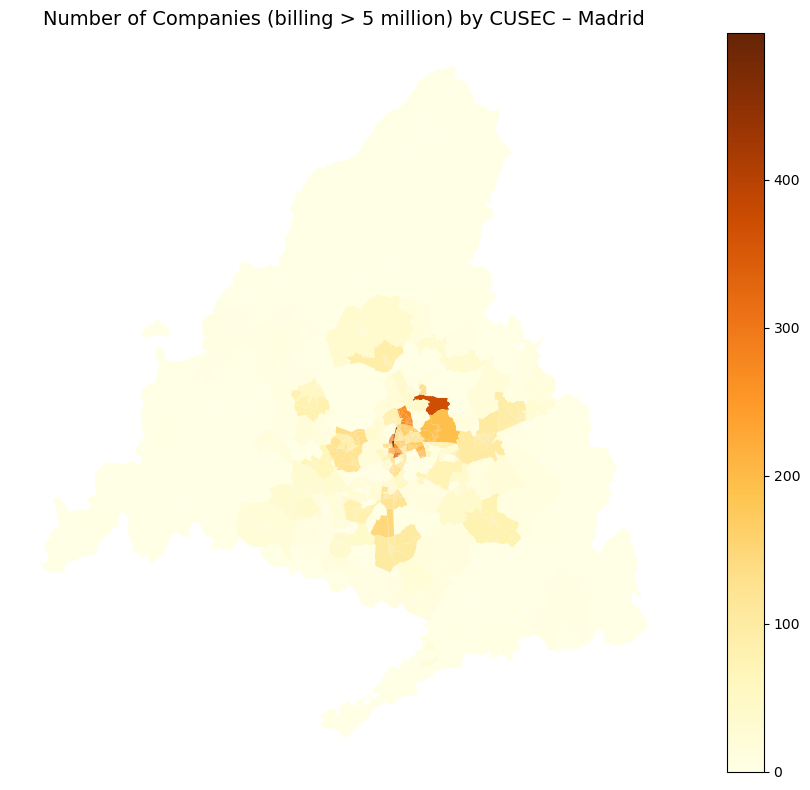

In [129]:
# Mapa de Cataluña – Total de medianas y grandes empresas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='Empresas_Med_Grande', cmap='PuBuGn', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Number of Companies (billing > 5 million) by CUSEC – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid – Total de medianas y grandes empresas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='Empresas_Med_Grande', cmap='YlOrBr', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Number of Companies (billing > 5 million) by CUSEC – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

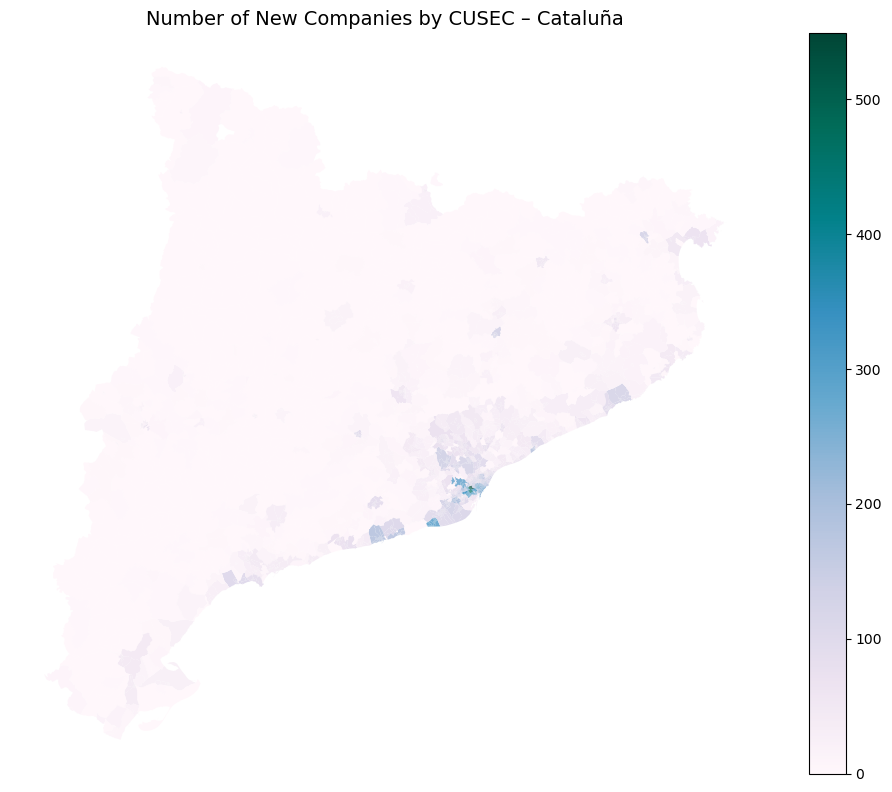

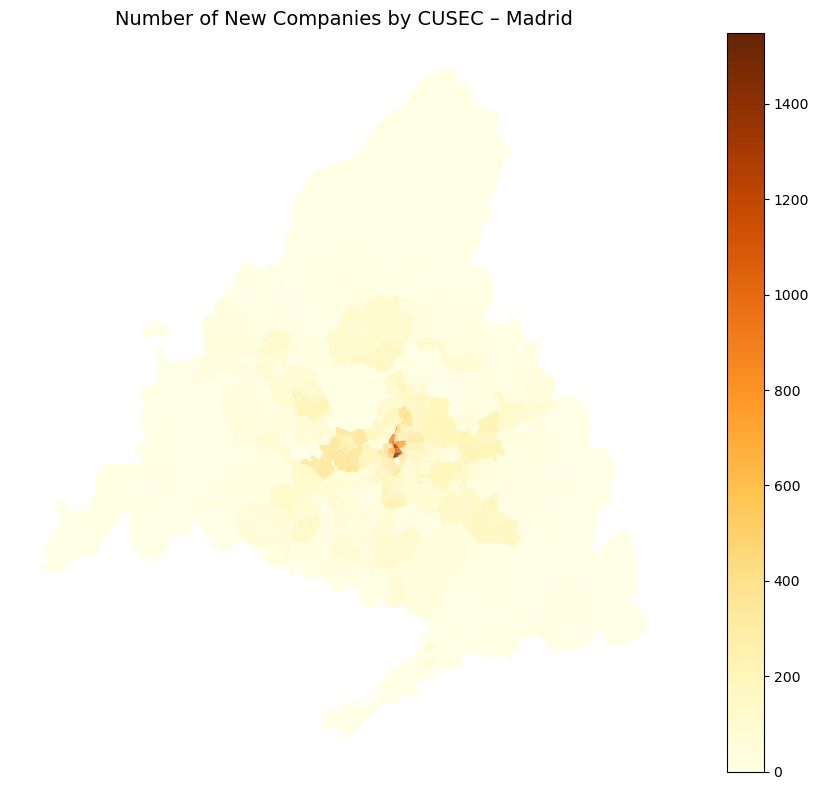

In [130]:
# Mapa de Cataluña – Total de empresas nuevas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_cat.plot(column='total_NumCompaniesNewCreation', cmap='PuBuGn', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Number of New Companies by CUSEC – Cataluña", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

# Mapa de Madrid – Total de empresas nuevas
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
resumen_mad.plot(column='total_NumCompaniesNewCreation', cmap='YlOrBr', linewidth=0.1, legend=True, ax=ax)
ax.set_title("Number of New Companies by CUSEC – Madrid", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

In [131]:
empresas_med_grandes_provincia = resumen.groupby('province')['Empresas_Med_Grande'].sum().reset_index()
empresas_med_grandes_provincia.columns = ['province', 'total_empresas_med_grande']
print(empresas_med_grandes_provincia)

   province  total_empresas_med_grande
0  Cataluña                   127023.0
1    Madrid                   244104.0


In [132]:
empresas_nuevas_provincia = resumen.groupby('province')['total_NumCompaniesNewCreation'].sum().reset_index()
empresas_nuevas_provincia.columns = ['province', 'total_empresas_nuevas']
print(empresas_nuevas_provincia)

   province  total_empresas_nuevas
0  Cataluña               404536.0
1    Madrid               813358.0


In [133]:
bancos_por_provincia = resumen.groupby('province')['num_bancos'].sum().reset_index()
bancos_por_provincia.columns = ['province', 'total_bancos']
print(bancos_por_provincia)


   province  total_bancos
0  Cataluña        1320.0
1    Madrid        1188.0
